# Classification with Imbalanced Data

## setup

In [5]:
import pandas as pd
import numpy as np # linear algebra
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, SCORERS, precision_recall_curve
from sklearn.metrics import average_precision_score, auc, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, LeaveOneOut

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

import graphviz

from sklearn.utils import resample

In [21]:
def score_prediction(y_test, y_pred):
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred):.3f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.3f}')
    print(f'F1:        {f1_score(y_test, y_pred):.3f}')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Credit Card problem

source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [3]:
df = pd.read_csv('input/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


/Users/giedrius/anaconda3/envs/scipy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


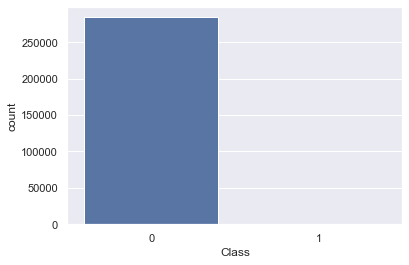

In [7]:
sns.countplot(df['Class']);

In [9]:
good = df[df['Class']==0]
fraud = df[df['Class']==1]

print(f'Fraudulent transactions: {len(fraud):,}; Good transactions: {len(good):,}')

Fraudulent transactions: 492; Good transactions: 284,315


### Full sample

In [43]:
#spliting the data for target and features
X = df.drop(columns=['Class'], axis=1)
y = df['Class'] #.astype('int')

In [44]:
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size = 0.7, random_state=42, stratify=y) # 
print(X_train.shape, X_test.shape)
print(f'Ratio of fraudulent transactions in train dataset: {y_train.mean()}, in test dataset: {y_test.mean()}')

(199364, 30) (85443, 30)
Ratio of fraudulent transactions in train dataset: 0.0017254870488152324, in test dataset: 0.0017321489179921118


In [50]:
y_pred = np.zeros(y_test.shape)
score_prediction(y_test, y_pred)

Accuracy:  0.998
Precision: 0.000
Recall:    0.000
F1:        0.000


/Users/giedrius/anaconda3/envs/scipy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
clf_tree = DecisionTreeClassifier(min_samples_split=5)
model_tree = clf_tree.fit(X_train, y_train)

In [49]:
y_pred = model_tree.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.999
Precision: 0.765
Recall:    0.703
F1:        0.732


### Simple under sampling

In [72]:
df_majority = X_train[y_train == 0]
df_minority = X_train[y_train == 1]
size_minor = len(df_minority)

y_majority = y_train[y_train == 0]
y_minority = y_train[y_train == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                   replace=False,    # sample with replacement
                   n_samples=size_minor,    # to match majority class
                   random_state=42)  # reproducible results

X_down_train = pd.concat([df_minority, df_majority_downsampled])
# print(X_down_train.shape)

y_majority_downsampled = y_majority[X_down.index]
y_down_train = pd.concat([y_minority, y_majority_downsampled])
# y_down_train.value_counts()

# sns.countplot(y_down_train);

In [71]:
clf_tree_down = DecisionTreeClassifier(min_samples_split=5)
model_tree_down = clf_tree_down.fit(X_down_train, y_down_train)
y_pred = model_tree_down.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.876
Precision: 0.012
Recall:    0.885
F1:        0.024


In [68]:
f1_score(y_test, y_pred)

0.025304322821815394

In [78]:
for size_minor in [100, 1000, 5000, 10000, 50000, 99000]:
    
    df_majority = X_train[y_train == 0]
    df_minority = X_train[y_train == 1]

    y_majority = y_train[y_train == 0]
    y_minority = y_train[y_train == 1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                   replace=False,    # sample with replacement
                   n_samples=size_minor,    # to match majority class
                   random_state=42)  # reproducible results

    X_down_train = pd.concat([df_minority, df_majority_downsampled])
    # print(X_down_train.shape)

    y_majority_downsampled = y_majority[df_majority_downsampled.index]
    y_down_train = pd.concat([y_minority, y_majority_downsampled])
    
    clf_tree_down = DecisionTreeClassifier(min_samples_split=5)
    model_tree_down = clf_tree_down.fit(X_down_train, y_down_train)
    y_pred = model_tree_down.predict(X_test)
    print(f'Training sample size: {len(X_down_train):,}, F1-score: {f1_score(y_test, y_pred):.3f}')

Training sample size: 444, F1-score: 0.016
Training sample size: 1,344, F1-score: 0.072
Training sample size: 5,344, F1-score: 0.218
Training sample size: 10,344, F1-score: 0.332
Training sample size: 50,344, F1-score: 0.595
Training sample size: 99,344, F1-score: 0.671


## Orange Telecom's Churn

The Orange Telecom's Churn Dataset, which consists of cleaned customer activity data (features), along with a churn label specifying whether a customer canceled the subscription, will be used to develop predictive models. Two datasets are made available here: The churn-80 and churn-20 datasets can be downloaded.

The two sets are from the same batch, but have been split by an 80/20 ratio. As more data is often desirable for developing ML models, let's use the larger set (that is, churn-80) for training and cross-validation purposes, and the smaller set (that is, churn-20) for final testing and model performance evaluation.

https://www.kaggle.com/mnassrib/telecom-churn-datasets

In [81]:
df = pd.read_csv("https://github.com/giedriusblazys/SDA_DS_class/raw/main/practice/input/churn-bigml-80.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [82]:
df.info()

In [89]:
def corr_plot(df):
    corr = df.corr()
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    )

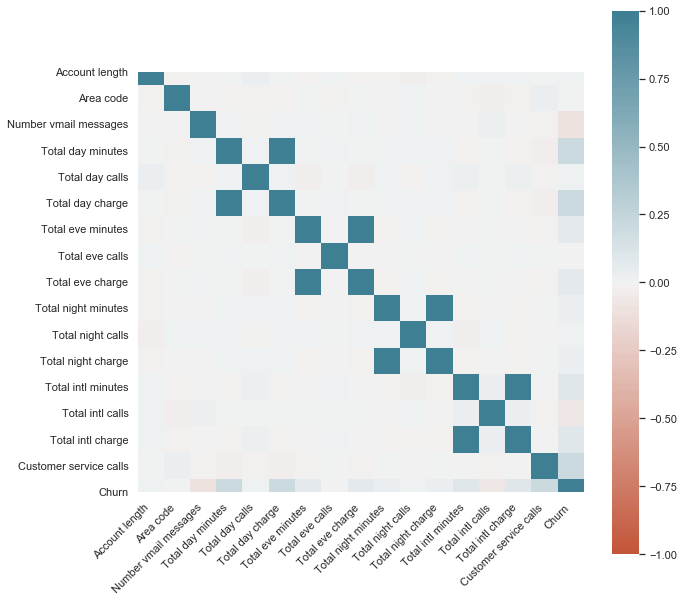

In [90]:
corr_plot(df)

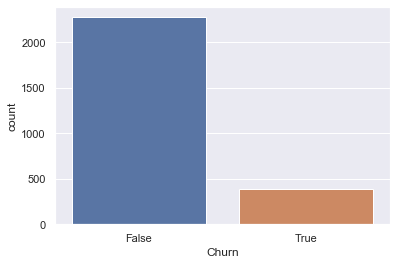

In [84]:
sns.countplot(x=df["Churn"]);

In [87]:
#spliting the data for target and features
X = df.drop(columns='Churn', axis=1)
y = df['Churn'].astype('int')

#creating the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state = 42, stratify=y)
print(X_train.shape, X_test.shape)

## One-hot encoder

s = (X_train.dtypes == 'object')
obj_cols = list(s[s].index)

OH_encoder = preprocessing.OneHotEncoder(drop='first')

X_train_array = OH_encoder.fit_transform(X_train[obj_cols]).toarray()
OH_cols_train = pd.DataFrame(X_train_array, columns = OH_encoder.get_feature_names_out())
X_test_array = OH_encoder.transform(X_test[obj_cols]).toarray()
OH_cols_test = pd.DataFrame(X_test_array, columns = OH_encoder.get_feature_names_out())
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(obj_cols, axis=1)
num_X_test = X_test.drop(obj_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
OH_X_train.columns

(799, 19) (1867, 19)


Index(['Account length', 'Area code', 'Number vmail messages',
       'Total day minutes', 'Total day calls', 'Total day charge',
       'Total eve minutes', 'Total eve calls', 'Total eve charge',
       'Total night minutes', 'Total night calls', 'Total night charge',
       'Total intl minutes', 'Total intl calls', 'Total intl charge',
       'Customer service calls', 'State_AL', 'State_AR', 'State_AZ',
       'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL',
       'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN',
       'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME',
       'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC',
       'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV',
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI',
       'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_VT', 'State_WA', 'State_

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()